In [1]:
print("Hello, Colab!")

Hello, Colab!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



In [4]:
# Load the dataset
file_path = '/content/drive/My Drive/nlp/dataset_final/daily_news/ms/MS_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


        Price   Open  Close   High      Volume
0      Ticker     MS     MS     MS          MS
1        Date    NaN    NaN    NaN         NaN
2  2020-06-10   42.3  41.16  42.69  14770900.0
3  2020-06-09  41.19  42.61  42.85  15090400.0
4  2020-06-08  42.71   42.4  42.85  12150300.0


In [5]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Price     0
Open      1
Close     1
High      1
Volume    1
dtype: int64
             Price   Open  Close   High     Volume
count         2618   2617   2617   2617       2617
unique        2618   1781   1765   1749       2597
top     2010-01-20  24.57  18.08  18.67  6955500.0
freq             1      6      7      7          2


In [9]:
import pandas as pd

# Step 1: Skip the first two junk rows and create a clean copy
data_cleaned = data.iloc[2:].copy()

# Step 2: Rename the 'Price' column to 'Date'
data_cleaned.rename(columns={'Price': 'Date'}, inplace=True)

# Step 3: Convert the 'Date' column to a proper datetime format
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])

# Now, you can sort by the 'Date' column without an error
data_cleaned = data_cleaned.sort_values(by='Date', ascending=True)

# Optional: Convert other columns to numeric if needed
for col in ['Open', 'Close', 'High', 'Volume']:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# Display the head of the cleaned and sorted DataFrame
print(data_cleaned.head())

           Date   Open  Close   High      Volume
2617 2010-01-20  21.88  21.79  22.23  21198800.0
2616 2010-01-21  21.55  20.87  21.73  56774400.0
2615 2010-01-22  20.38  19.78  20.76  46713700.0
2614 2010-01-25  20.08  19.74  20.29  21100900.0
2613 2010-01-26  19.69  19.44  20.13  24376400.0


In [11]:
import pandas as pd

# --- FIX: Convert columns to a numeric type before calculations ---
# Use errors='coerce' to turn any non-numeric values into NaN (Not a Number)
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day's features
data['Movement'] = data['Movement'].shift(1)

# Drop rows with NaN values that were created during calculations
data = data.dropna(subset=['Movement'])

# Convert Movement into a binary target variable (1 for up, 0 for down/flat)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print("Distribution of the 'Movement' target variable:")
print(data['Movement'].value_counts().sort_index())

Distribution of the 'Movement' target variable:
Movement
0    1339
1    1276
Name: count, dtype: int64


In [12]:
# Calculate daily returns (in percentage)
data['Daily_Return'] = data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data = data.dropna(subset=['Volatility'])

In [13]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [14]:
data.tail(20)


,Price,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
2598,2010-02-17,19.86,19.52,19.93,16590200.0,1,0.463201,1.698880,19.43,19.59,12147400.0,-0.562948,1.687073
2599,2010-02-16,19.56,19.83,19.91,15765300.0,1,1.588115,1.343050,19.52,19.93,16590200.0,0.463201,1.698880
2600,2010-02-12,18.97,19.36,19.46,16628700.0,0,-2.370146,1.503753,19.83,19.91,15765300.0,1.588115,1.343050
2601,2010-02-11,19.53,19.33,19.62,18823500.0,1,-0.154959,1.456040,19.36,19.46,16628700.0,-2.370146,1.503753
2602,2010-02-10,19.30,19.61,19.78,13858300.0,0,1.448526,1.603627,19.33,19.62,18823500.0,-0.154959,1.456040
2603,2010-02-09,19.14,19.34,19.46,19517300.0,0,-1.376849,1.732621,19.61,19.78,13858300.0,1.448526,1.603627
2604,2010-02-08,19.31,18.96,19.63,14517500.0,0,-1.964840,1.548541,19.34,19.46,19517300.0,-1.376849,1.732621
2605,2010-02-05,18.94,19.43,19.45,25551300.0,0,2.478903,1.869919,18.96,19.63,14517500.0,-1.964840,1.548541
2606,2010-02-04,19.68,18.98,19.71,29785300.0,1,-2.316006,2.165907,19.43,19.45,25551300.0,2.478903,1.869919
2607,2010-02-03,20.07,19.88,20.26,18498800.0,1,4.741834,3.132951,18.98,19.71,29785300.0,-2.316006,2.165907


In [15]:
data.rename(columns={'Price': 'Date'}, inplace=True)

In [16]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [17]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1',
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                 0.031875
Close_lag1          -0.015859
High_lag1           -0.006101
Volume_lag1          0.024156
Daily_Return_lag1   -0.029216
Volatility_lag1      0.046588
Name: Movement, dtype: float64


In [18]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


     Open  Close_lag1 High_lag1 Volume_lag1  Daily_Return_lag1  \
9   37.64       38.53     39.11  11179200.0          -2.849218   
10  37.21       37.79      38.1   8649500.0          -1.920581   
11  39.95       37.37     37.87  13102100.0          -1.111405   
12  38.70       37.54      40.0  17615900.0           0.454910   
13  35.40       39.62     39.67  25892400.0           5.540757   

    Volatility_lag1  
9          1.260023  
10         0.963911  
11         1.001892  
12         1.587032  
13         3.314597  
9     0
10    0
11    1
12    1
13    0
Name: Movement, dtype: int64


In [19]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2020-06-01', '2020-05-29', '2020-05-28', '2020-05-27',
               '2020-05-26', '2020-05-22', '2020-05-21', '2020-05-20',
               '2020-05-19', '2020-05-18',
               ...
               '2010-02-02', '2010-02-01', '2010-01-29', '2010-01-28',
               '2010-01-27', '2010-01-26', '2010-01-25', '2010-01-22',
               '2010-01-21', '2010-01-20'],
              dtype='datetime64[ns]', name='Date', length=2609, freq=None)


In [20]:
X.index = data.index
print(X.index)

DatetimeIndex(['2020-06-01', '2020-05-29', '2020-05-28', '2020-05-27',
               '2020-05-26', '2020-05-22', '2020-05-21', '2020-05-20',
               '2020-05-19', '2020-05-18',
               ...
               '2010-02-02', '2010-02-01', '2010-01-29', '2010-01-28',
               '2010-01-27', '2010-01-26', '2010-01-25', '2010-01-22',
               '2010-01-21', '2010-01-20'],
              dtype='datetime64[ns]', name='Date', length=2609, freq=None)


In [21]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]

    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2018-08-31 to 2020-06-01
Test Dates: 2016-12-09 to 2018-08-30
--------------------------------------------------
Fold 2:
Train Dates: 2016-12-09 to 2020-06-01
Test Dates: 2015-03-24 to 2016-12-08
--------------------------------------------------
Fold 3:
Train Dates: 2015-03-24 to 2020-06-01
Test Dates: 2013-07-02 to 2015-03-23
--------------------------------------------------
Fold 4:
Train Dates: 2013-07-02 to 2020-06-01
Test Dates: 2011-10-07 to 2013-07-01
--------------------------------------------------
Fold 5:
Train Dates: 2011-10-07 to 2020-06-01
Test Dates: 2010-01-20 to 2011-10-06
--------------------------------------------------


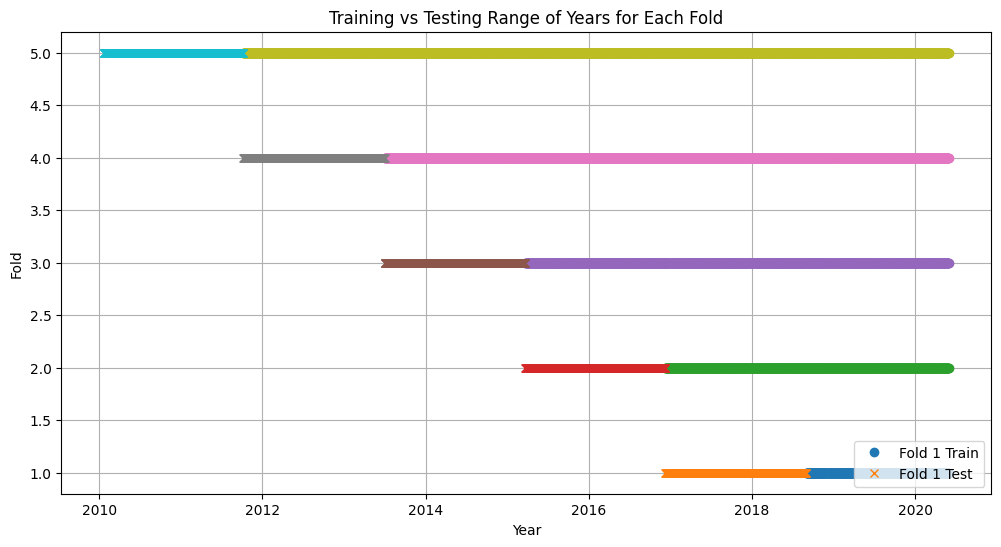

In [22]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Fold 1 Confusion Matrix:
[[212   6]
 [ 13 203]]


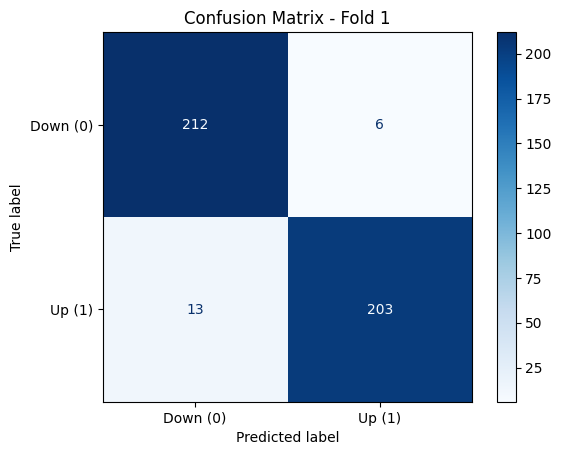

Fold 1 Accuracy: 0.96
--------------------------------------------------

Fold 2 Confusion Matrix:
[[233   2]
 [ 46 153]]


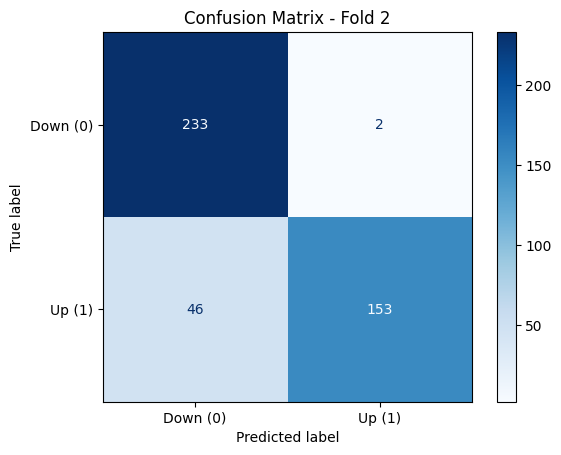

Fold 2 Accuracy: 0.89
--------------------------------------------------

Fold 3 Confusion Matrix:
[[228   1]
 [ 54 151]]


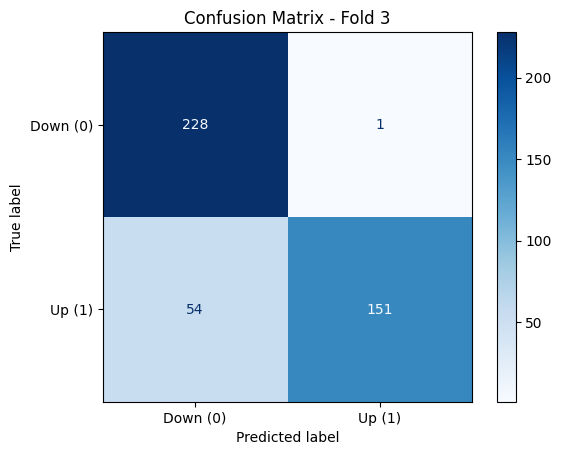

Fold 3 Accuracy: 0.87
--------------------------------------------------

Fold 4 Confusion Matrix:
[[213  19]
 [ 25 177]]


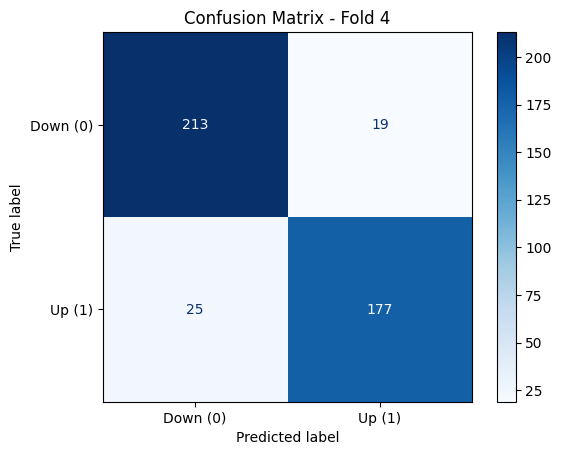

Fold 4 Accuracy: 0.90
--------------------------------------------------

Fold 5 Confusion Matrix:
[[200   2]
 [ 29 203]]


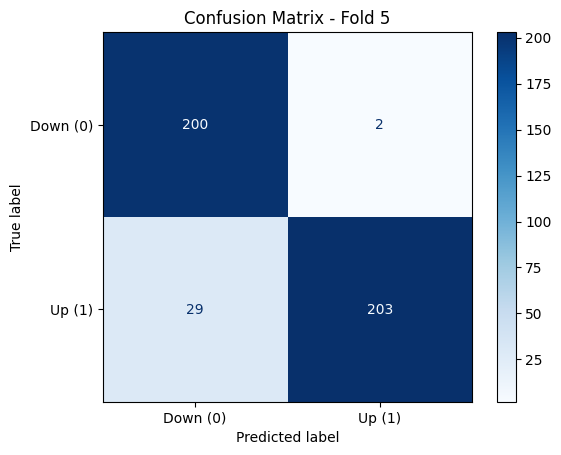

Fold 5 Accuracy: 0.93
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.91
Precision: 0.97
Recall: 0.84
F1-Score: 0.90
ROC-AUC: 0.99


In [23]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


Fold 1 - Balanced Class Distribution:
Movement
0    219
1    219
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[212   6]
 [ 13 203]]


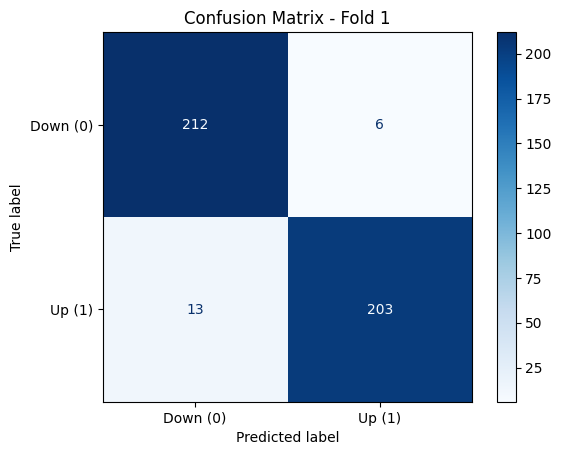

Fold 1 Accuracy: 0.96
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    435
1    435
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[233   2]
 [ 44 155]]


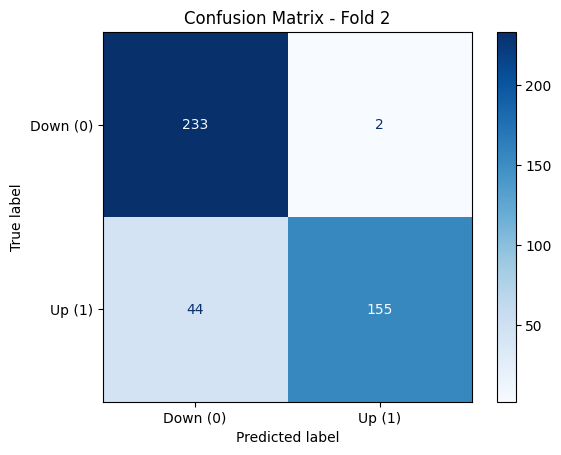

Fold 2 Accuracy: 0.89
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    634
1    634
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[227   2]
 [ 39 166]]


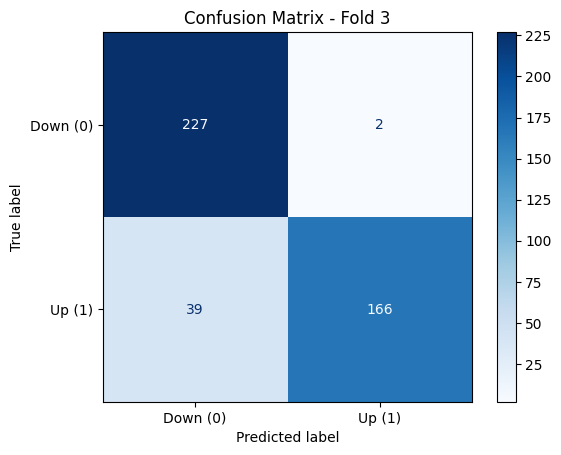

Fold 3 Accuracy: 0.91
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    839
1    839
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[209  23]
 [ 18 184]]


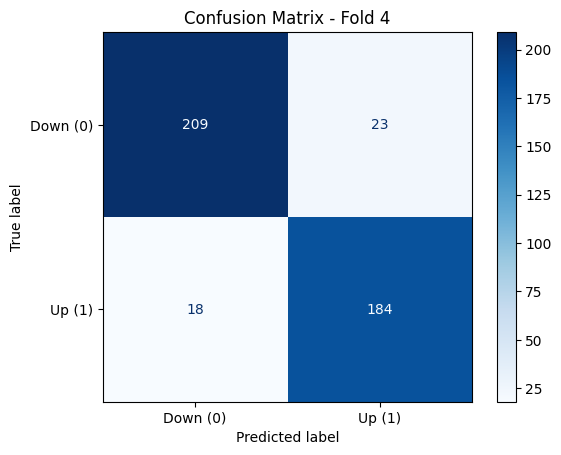

Fold 4 Accuracy: 0.91
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    1041
1    1041
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[198   4]
 [ 17 215]]


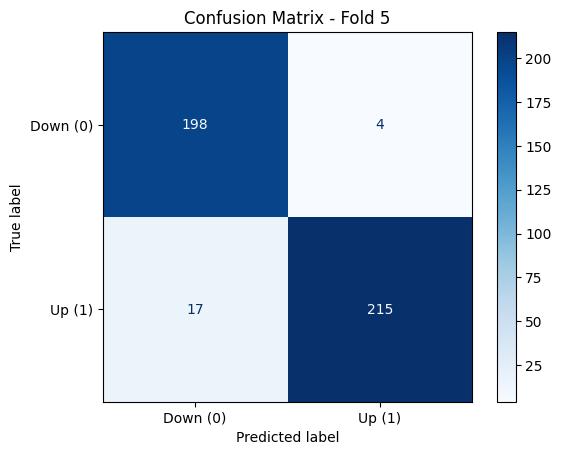

Fold 5 Accuracy: 0.95
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.92
Precision: 0.96
Recall: 0.87
F1-Score: 0.91
ROC-AUC: 0.99


In [24]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


In [25]:
data.to_csv('/content/drive/My Drive/nlp/dataset_final/daily_news/ms/MS_numerical_LR.csv')